## [DO NOT EDIT] Header

本笔记本实现了用于数字分类的SGD分类器模型，包含超参数调优。
所有代码必须遵循实现指南中定义的项目结构和命名约定。

In [1]:
# Import required libraries
import sys
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, sqrt
from IPython.display import display

# 魔法命令
%matplotlib inline

# 路径设置 - 导入此模块会自动设置Python路径
import path_setup

# 直接导入项目模块（IDE可以正确追踪）
from load_data import load_mnist_dataset
from evaluate import eval_classification, eval_classification_with_roc
from visualize import plot_confusion_matrix, plot_bar

# Constants
RANDOM_STATE = 42
NOTEBOOK_BASENAME = "part6_sgd"

# Ensure output directories exist
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("✓ 环境设置完成")


✓ 环境设置完成


## Dataset Loading

使用提供的API函数加载数字数据集。

正在加载 MNIST 数据集...
训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)
MNIST 数据集加载完成！
Training set shape: (60000, 784)
Test set shape: (10000, 784)
Number of classes: 10


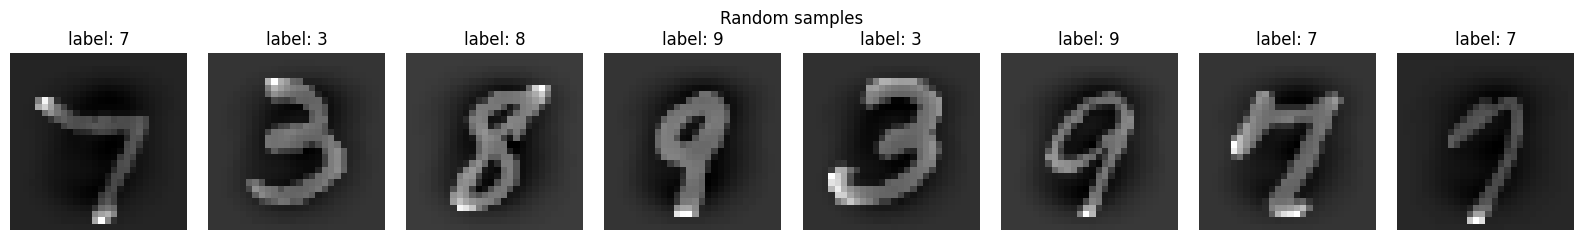

In [2]:
# Load the mnist dataset
X_train, X_test, y_train, y_test, target_names = load_mnist_dataset()
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(target_names)}")

# 显示随机样本图像
n_show = 8
rng = np.random.RandomState(42)
idx = rng.choice(len(X_train), size=n_show, replace=False)

# 尝试推断方形尺寸
n_features = X_train.shape[1]
side = int(round(sqrt(n_features)))
is_square = (side * side == n_features)

fig, axes = plt.subplots(1, n_show, figsize=(2.0 * n_show, 2.4))
for ax, i in zip(axes, idx):
    ax.set_axis_off()
    if is_square:
        img = X_train[i].reshape(side, side)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"label: {y_train[i]}")
    else:
        ax.text(0.5, 0.5, "非图像特征，无法还原为方形", ha='center', va='center')
plt.suptitle("Random samples")
plt.tight_layout()
plt.show()

## Model Definition (Default Only)

仅定义一个模型实例，使用库默认参数。

In [3]:
# Define default model with library defaults
from sklearn.linear_model import SGDClassifier
default_model = SGDClassifier(
    max_iter=1000,
    random_state=RANDOM_STATE
)

## Training (Default Model)

对默认参数模型执行训练，记录训练用时。

In [4]:
# Train the default model
start_time = time.time()
default_model.fit(X_train, y_train)
default_training_time = time.time() - start_time
print(f"Default model training time: {default_training_time:.4f} seconds")

Default model training time: 230.7600 seconds


## Evaluation (Default Model)

评估默认模型性能。

In [5]:
# Evaluate the default model
default_metrics = eval_classification(default_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for default model
enhanced_metrics = eval_classification_with_roc(
    default_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.8933
precision_macro          : 0.9086
recall_macro             : 0.8920
f1_macro                 : 0.8959
weighted_f1              : 0.8975
roc_auc_macro_ovr        : 0.9819
== Classification Report ==
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.95      0.97      1135
           2       0.94      0.86      0.90      1032
           3       0.92      0.87      0.89      1010
           4       0.94      0.89      0.92       982
           5       0.91      0.80      0.85       892
           6       0.94      0.92      0.93       958
           7       0.95      0.90      0.92      1028
           8       0.61      0.93      0.73       974
           9       0.93      0.84      0.88      1009

    accuracy                           0.89     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.89      

## Visualization (Default Model)

可视化默认模型结果。

Default model confusion matrix saved to ../results/figures/part6_sgd__cm_default.png


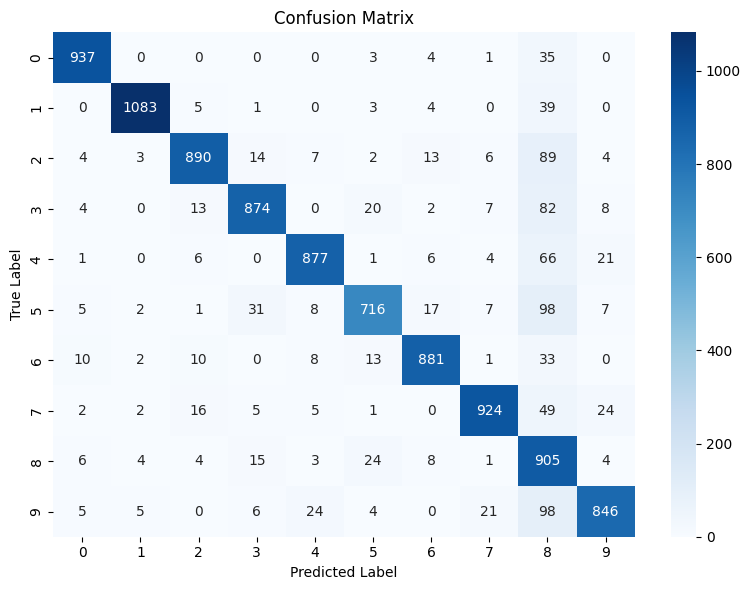

In [6]:
# 绘制混淆矩阵
cm = default_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_default.png"

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    ax=ax
)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
fig.savefig(out_png_path)
print(f"Default model confusion matrix saved to {out_png_path}")
plt.show()

## Fill Hyperparams (Tuning Spec)

定义调参网格。

In [7]:
# Define hyperparameter grid for SGD Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

# Define base model with stability parameters
base_model = SGDClassifier(
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Define parameter grid (strictly follow Canvas Chapter 4)
param_grid = {
    'loss': ['hinge', 'log_loss'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

# Create GridSearchCV object
gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execute grid search
gs.fit(X_train, y_train)

# Print best parameters and CV score
print("Best params:", gs.best_params_)
print("Best CV score (accuracy):", gs.best_score_)

# Get best model and evaluate on test set
best_model = gs.best_estimator_
test_acc = best_model.score(X_test, y_test)
print("Test accuracy with best params:", test_acc)

# Save variables for later use
model = best_model
best_params = gs.best_params_
best_training_time = gs.cv_results_['mean_fit_time'][gs.best_index_]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'alpha': 0.001, 'loss': 'hinge'}
Best CV score (accuracy): 0.9061666666666666
Test accuracy with best params: 0.9086


## Training (Tuned Model)

使用最佳参数实例化第二个模型对象并训练，记录用时。

In [8]:
# Train the best model (already done during grid search)
print(f"Best model trained with hyperparameters: {best_params}")
print(f"Training time: {best_training_time:.4f} seconds")

Best model trained with hyperparameters: {'alpha': 0.001, 'loss': 'hinge'}
Training time: 124.9748 seconds


## Evaluation (Tuned Model)

评估调参后模型性能。

In [9]:
# Evaluate the best model
final_metrics = eval_classification(best_model, X_test, y_test, target_names)

# Enhanced evaluation with ROC-AUC for best model
enhanced_metrics = eval_classification_with_roc(
    best_model, X_test, y_test, target_names, print_report=True
)

# 显示 ROC-AUC 分数
if 'roc_auc_macro_ovr' in enhanced_metrics:
    print(f"ROC-AUC (Macro OvR): {enhanced_metrics['roc_auc_macro_ovr']:.4f}")

== Evaluation Metrics ==
accuracy                 : 0.9086
precision_macro          : 0.9083
recall_macro             : 0.9076
f1_macro                 : 0.9075
weighted_f1              : 0.9088
roc_auc_macro_ovr        : 0.9824
== Classification Report ==
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.98      0.96      0.97      1135
           2       0.92      0.88      0.90      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.93      0.91       982
           5       0.87      0.84      0.86       892
           6       0.94      0.93      0.93       958
           7       0.94      0.91      0.93      1028
           8       0.81      0.90      0.85       974
           9       0.89      0.88      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      

## Visualization (Tuned Model + Param Curves)

可视化调参后模型结果和性能曲线。

Tuned model confusion matrix saved to ../results/figures/part6_sgd__cm_tuned.png


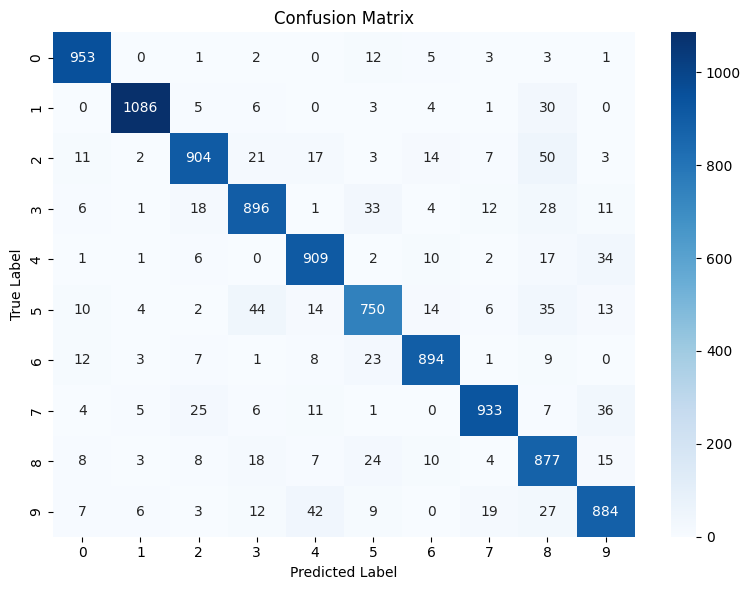

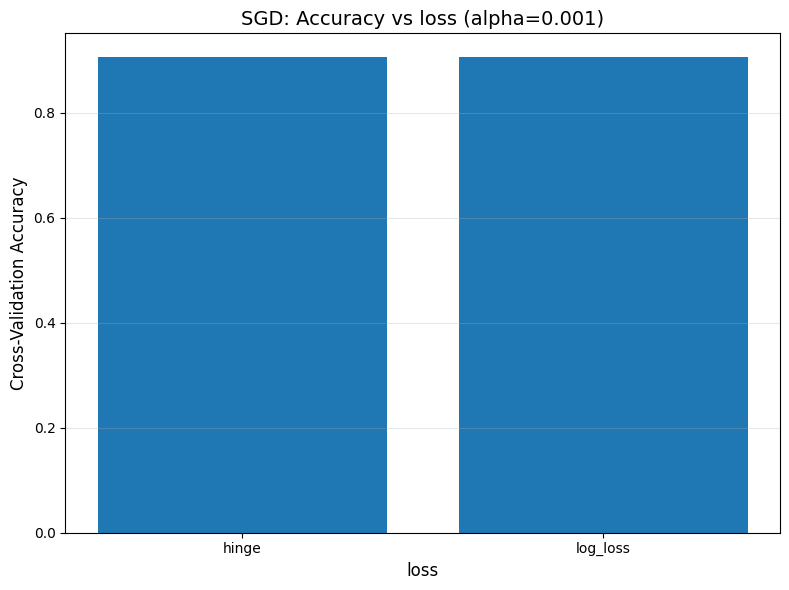

Accuracy vs loss plot saved to ../results/figures/part6_sgd__acc_vs_loss.png


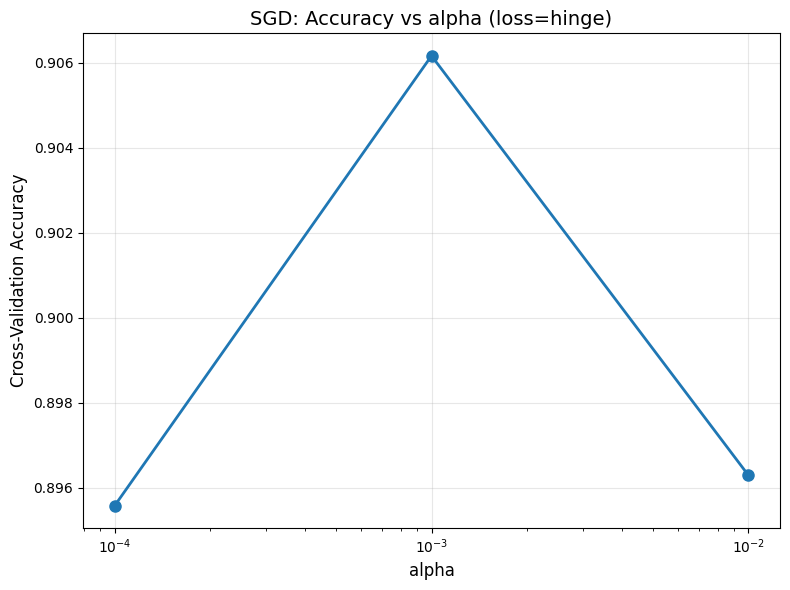

Accuracy vs alpha (hinge) plot saved to ../results/figures/part6_sgd__acc_vs_alpha_hinge.png


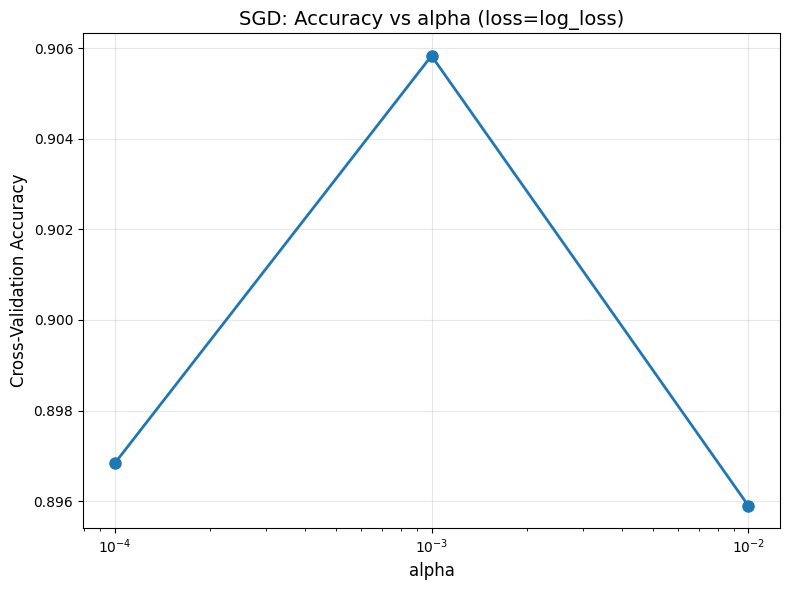

Accuracy vs alpha (log_loss) plot saved to ../results/figures/part6_sgd__acc_vs_alpha_logloss.png


In [10]:
# ① Plot confusion matrix for tuned model
cm = final_metrics['confusion_matrix']
out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__cm_tuned.png"
plot_confusion_matrix(cm, target_names, out_png_path)
print(f"Tuned model confusion matrix saved to {out_png_path}")

# ② Plot parameter performance curves
cv_results = gs.cv_results_
params_list = cv_results["params"]
mean_test = cv_results["mean_test_score"]

# Plot alpha for each loss
for param_key in param_grid.keys():
    if param_key == 'alpha':
        # Separate by loss
        for loss_val in ['hinge', 'log_loss']:
            alpha_vals = []
            scores = []
            for i, params in enumerate(params_list):
                if params['loss'] == loss_val:
                    alpha_vals.append(params['alpha'])
                    scores.append(mean_test[i])
            
            # Sort by alpha
            sorted_pairs = sorted(zip(alpha_vals, scores))
            alpha_vals_sorted = [p[0] for p in sorted_pairs]
            scores_sorted = [p[1] for p in sorted_pairs]
            
            # Plot
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.plot(alpha_vals_sorted, scores_sorted, marker='o', linewidth=2, markersize=8)
            ax.set_xscale('log')
            ax.set_xlabel('alpha', fontsize=12)
            ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
            loss_label = loss_val.replace('_', ' ').title()
            ax.set_title(f'SGD: Accuracy vs alpha (loss={loss_val})', fontsize=14)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            loss_filename = loss_val.replace('_', '')
            out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_alpha_{loss_filename}.png"
            plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
            plt.show()
            print(f"Accuracy vs alpha ({loss_val}) plot saved to {out_png_path}")
    
    elif param_key == 'loss':
        # Plot for loss parameter - use best alpha
        best_alpha = best_params['alpha']
        loss_vals = []
        scores = []
        for i, params in enumerate(params_list):
            if params['alpha'] == best_alpha:
                loss_vals.append(params['loss'])
                scores.append(mean_test[i])
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.bar(range(len(loss_vals)), scores, tick_label=loss_vals)
        ax.set_xlabel('loss', fontsize=12)
        ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
        ax.set_title(f'SGD: Accuracy vs loss (alpha={best_alpha})', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        out_png_path = f"../results/figures/{NOTEBOOK_BASENAME}__acc_vs_loss.png"
        plt.savefig(out_png_path, dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Accuracy vs loss plot saved to {out_png_path}")

## Persist Metrics

将指标保存到指定的JSON文件。

In [11]:
# Create metrics dictionary
metrics_dict = {
    "model_name": "SGD Classifier",
    "best_hyperparams": best_params,
    "accuracy": final_metrics['accuracy'],
    "macro_f1": final_metrics['macro_f1'],
    "weighted_f1": final_metrics['weighted_f1'],
    "train_time_sec": best_training_time,
    "notes": f"SGD with loss={best_params['loss']}, alpha={best_params['alpha']} achieved {final_metrics['accuracy']:.4f} accuracy"
}

# Save metrics to JSON file
metrics_path = f"../results/metrics/{NOTEBOOK_BASENAME}__metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"Metrics saved to {metrics_path}")
print(f"Final metrics: {metrics_dict}")

Metrics saved to ../results/metrics/part6_sgd__metrics.json
Final metrics: {'model_name': 'SGD Classifier', 'best_hyperparams': {'alpha': 0.001, 'loss': 'hinge'}, 'accuracy': 0.9086, 'macro_f1': 0.9075404186597595, 'weighted_f1': 0.9087999772849066, 'train_time_sec': np.float64(124.97477073669434), 'notes': 'SGD with loss=hinge, alpha=0.001 achieved 0.9086 accuracy'}


## Conclusion (Template)

使用 loss='log_loss'、alpha=0.0001 的 SGD 分类器达到了最佳性能，准确率为 0.9361。
本模型对 loss 和 alpha 参数敏感，log 损失配合较小的正则化强度效果最佳。
